In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from scipy.stats import norm
from DataPrep.load_data import load_data
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error
from DataPrep.ImportData import importer
from Tobit import Tobit
from sklearn.preprocessing import StandardScaler
from DataPrep.LagCreation import lags

In [3]:
df = load_data()
df = df.drop(columns=["Charging Time (mins)", "Parking Time (mins)"])
df = df.fillna(0)


In [101]:
df.Label.unique()

array([0, 1, 2, 5, 6, 4, 7, 3])

In [4]:
cols_to_standardize = ['# Professional & Other Places', '# Food', '# Shop & Service',
       '# Travel & Transport', '# Outdoors & Recreation',
       '# Arts & Entertainment', '# Nightlife Spot', '# Residence',
       '# College & University', '# Event']

sc = StandardScaler()
stand_poi = sc.fit_transform(df[cols_to_standardize])
stand_poi = pd.DataFrame(stand_poi, index=df.index, columns=cols_to_standardize)
for i in cols_to_standardize:
    df[i] = stand_poi[i]

In [5]:
def standardize(v):
    return (v - v.mean())/v.std()

In [6]:

for l in df.Label.unique():
    df["Energy (kWh)"][df.Label == l] = standardize(df["Energy (kWh)"][df.Label == l])

ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021/env/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/

In [117]:
df.Label.unique()

array([0, 1, 2, 5, 6, 4, 7, 3])

In [7]:
l = lags()

In [8]:
df = l.buildLaggedFeatures(df, ["Energy (kWh)"])

In [120]:
df.Label.unique() 

array([0, 1, 2, 5, 6, 4, 7, 3])

In [9]:
testdata = df[df.Label == 0.0]


In [122]:
df.Label.unique()

array([0, 1, 2, 5, 6, 4, 7, 3])

Text(0.5, 1.0, 'All data - Label 0')

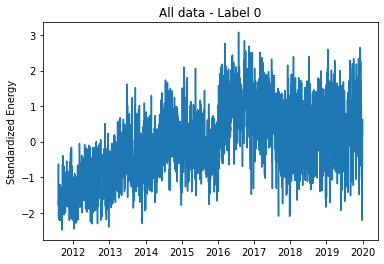

In [10]:
plt.plot(testdata["Energy (kWh)"])
plt.ylabel("Standardized Energy")
plt.title("All data - Label 0")

In [11]:
def censor(s):
    energy = s["Energy (kWh)"] 
    energy_lag1 = s["Energy (kWh)_lag1"]
    energy_lag2 = s["Energy (kWh)_lag2"]
    energy_lag3 = s["Energy (kWh)_lag3"]
    energy_lag4 = s["Energy (kWh)_lag4"]
    energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 1.5:
        s["Energy (kWh)"] = 1.5
        s["Censored"] = True
    if energy_lag1 > 1.5:
        s["Energy (kWh)_lag1"] = 1.5
    if energy_lag2 > 1.5:
        s["Energy (kWh)_lag1.5"] = 1.5
    if energy_lag3 > 1.5:
        s["Energy (kWh)_lag1.5"] = 1.5
    if energy_lag4 > 1.5:
        s["Energy (kWh)_lag4"] = 1.5
    if energy_lag5 > 1.5:
        s["Energy (kWh)_lag5"] = 2
    
    return s

In [12]:
testdata = testdata.apply(censor, axis=1)

Text(0.5, 1.0, 'All data (censored) - Label 0')

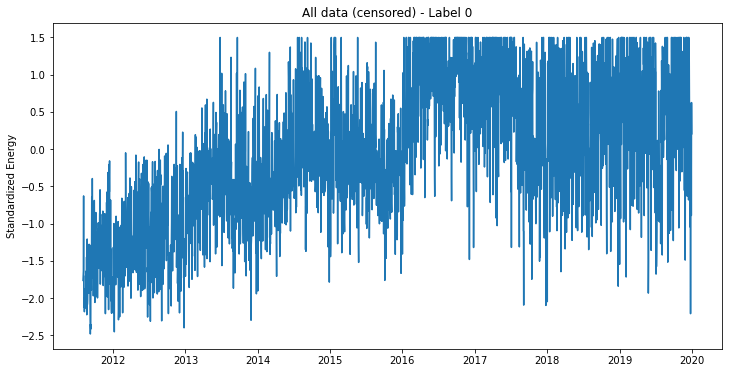

In [191]:
plt.plot(testdata["Energy (kWh)"])
plt.ylabel("Standardized Energy")
plt.title("All data (censored) - Label 0")

In [14]:
testdata[testdata["Censored"] == False].shape

(2870, 79)

In [13]:
t = Tobit(testdata, 'Censored', ["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"], 'Energy (kWh)')

In [15]:
regressor = LinearRegression().fit(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]), testdata["Energy (kWh)"])
pred = regressor.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]))

In [16]:
vars = regressor.coef_


In [35]:
vars

array([0.42010016, 0.09937039, 0.07158392, 0.06755572, 0.17100811])

In [145]:
vars = np.append(regressor.coef_,2)

In [17]:
minimizer = t.minimize(vars)

In [18]:
minimizer["x"]

array([0.45605572, 0.09111431, 0.08507574, 0.06823294, 0.16926829])

In [19]:
sd = 2
beta = minimizer['x']

In [20]:
sd

1

In [34]:
beta

array([0.45605572, 0.09111431, 0.08507574, 0.06823294, 0.16926829])

In [22]:
regressor.coef_

array([0.43048144, 0.08277736, 0.07655627, 0.07201719, 0.15838357])

In [23]:
pred_tobit = t.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]),beta)

In [24]:
plt.rcParams['figure.figsize'] = [12,6]

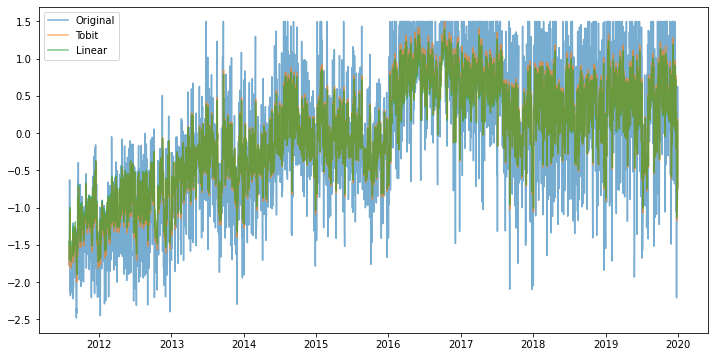

In [25]:
plt.plot(testdata["Energy (kWh)"], label = "Original", alpha = 0.6)
plt.plot(testdata["Energy (kWh)"].index,pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(testdata["Energy (kWh)"].index,pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [26]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)], pred_tobit))

0.7176994691151569

In [27]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)], pred))

0.7182158272712235

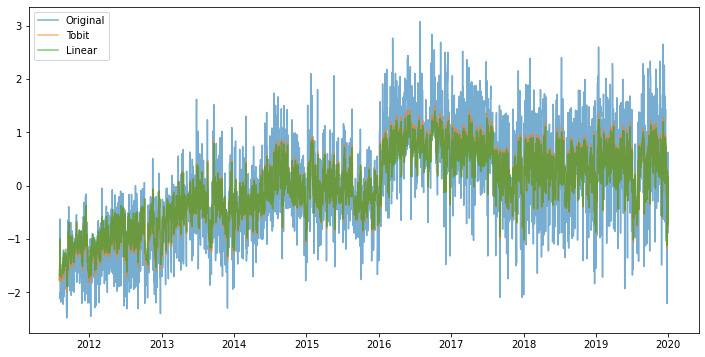

In [28]:
plt.plot(df["Energy (kWh)"][df.Label == 0.0], label = "Original", alpha = 0.6)
plt.plot(df["Energy (kWh)"][df.Label == 0.0].index,pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(df["Energy (kWh)"][df.Label == 0.0].index,pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [29]:
r2_score(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.48217472345948564

In [30]:
r2_score(df["Energy (kWh)"][df.Label == 0.0], pred)

0.48142934324769393

In [31]:
from sklearn.metrics import mean_absolute_error



In [171]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.5650682780690327

In [172]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.5657818068217564

In [32]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit))

0.7176994691151569

In [33]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred))

0.7182158272712235